In [1]:
import os

import numpy as np
import pandas as pd

import pcl
import pyntcloud
import matplotlib.pyplot as plt

In [2]:
seq_list = {
  0 : "unlabeled",
  1 : "outlier",
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  40: "road",
  44: "parking",
  48: "sidewalk",
  49: "other-ground",
  50: "building",
  51: "fence",
  52: "other-structure",
  60: "lane-marking",
  70: "vegetation",
  71: "trunk",
  72: "terrain",
  80: "pole",
  81: "traffic-sign",
  99: "other-object",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [3]:
obstacle_lst = {
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [358]:
scan = np.fromfile('dataset/sequences/00/velodyne/000009.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('dataset/sequences/00/labels/000009.label', dtype=np.uint32)
label = label.reshape((-1))

In [359]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
for seg in unq:
    if seg in list(seq_list.keys()):
        print(seg,seq_list[seg])

0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
72 terrain
40 road
10 car
44 parking
80 pole
81 traffic-sign
50 building
51 fence
52 other-structure
48 sidewalk
60 lane-marking
254 moving-person
255 moving-motorcyclist


In [360]:
scan = scan[:,:3]
scan

array([[57.516327 ,  8.860495 ,  2.1762035],
       [57.860134 ,  9.006442 ,  2.1881773],
       [58.05174  ,  9.22336  ,  2.1951373],
       ...,
       [ 3.8257542, -1.4199586, -1.7649935],
       [ 3.8513634, -1.4169728, -1.7760001],
       [ 3.888965 , -1.4179859, -1.7930062]], dtype=float32)

In [361]:
test_cloud = pyntcloud.PyntCloud(pd.DataFrame(scan,columns=['x','y','z']))

test_cloud.points['seg_id'] = pd.Series(label)

seg_count = test_cloud.points.groupby(test_cloud.points['seg_id']).count()
seg_count['Proportion'] = seg_count['x'] / seg_count['x'].sum() * 100
np.around(seg_count,2)

,x,y,z,Proportion
seg_id,,,,
0,2111,2111,2111,1.74
1,2,2,2,0.00
10,7429,7429,7429,6.12
40,27625,27625,27625,22.76
44,8297,8297,8297,6.84
48,18519,18519,18519,15.26
50,26218,26218,26218,21.60
51,709,709,709,0.58
52,881,881,881,0.73


In [362]:
test_cloud.plot(use_as_color='seg_id', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-1.324129343032837, 45.91697978973389, 3.206…

In [363]:
is_parking = ~test_cloud.points['seg_id'].isin(list(obstacle_lst.keys()))
test_cloud.points['is_parking'] = pd.Series(is_parking)

In [364]:
test_cloud.plot(use_as_color='is_parking', cmap="RdYlGn", output_name="is_parking")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-1.324129343032837, 45.91697978973389, 3.206…

In [365]:
is_parking = test_cloud.points['is_parking'] != 1
test_cloud.apply_filter(is_parking)

In [366]:
test_cloud.plot()

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.5293570756912231, 28.29741406440735, -0.74…

In [293]:
n_voxels = 50
voxelgrid_id = test_cloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=n_voxels)

In [294]:
%time cluster_id = test_cloud.add_scalar_field("euclidean_clusters",voxelgrid_id=voxelgrid_id)

CPU times: user 904 ms, sys: 225 µs, total: 905 ms
Wall time: 909 ms


In [295]:
test_cloud.plot(use_as_color=cluster_id, cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.5293570756912231, 28.29741406440735, -0.74…

In [300]:
test_cloud.points[test_cloud.points.columns[-1]].nunique()

10

In [559]:
clusters = test_cloud.points.groupby([test_cloud.points.columns[-1]]).agg({ 'x':['min','max'],
                                                                            'y':['min','max'],
                                                                            'z':['min','max'] })
def get_bounding_boxes(clusters):
    box_coord_list = []
    for i in range(len(clusters)):
        x_min, x_max, y_min, y_max, z_min, z_max =  list(clusters.iloc[i])
        box = np.zeros([8, 3])
        box[0, :] = [x_min, y_min, z_min]
        box[1, :] = [x_max, y_min, z_min]
        box[2, :] = [x_max, y_max, z_min]
        box[3, :] = [x_min, y_max, z_min]
        box[4, :] = [x_min, y_min, z_max]
        box[5, :] = [x_max, y_min, z_max]
        box[6, :] = [x_max, y_max, z_max]
        box[7, :] = [x_min, y_max, z_max]
        box = np.transpose(box)
        box_coord_list.append(box)
    return box_coord_list

In [669]:
def pipeline(scan, label, obstacle_lst, n_voxels=40, verbose=False, user):
    
    # get segment id
    label = [seg & 0xFFFF for seg in label]
    unq = list(set(label))
    
    #inference on seq:
    label = user.infer()
    # get segments 
    if verbose:
        print('get segments')
    pcloud = pyntcloud.PyntCloud(pd.DataFrame(scan,columns=['x','y','z']))
    pcloud.points['seg_id'] = pd.Series(label)
    
    # filter needed segments
    if verbose:
        print('filter needed segments')
    is_obstacle = ~pcloud.points['seg_id'].isin(list(obstacle_lst.keys()))
    pcloud.points['is_obstacle'] = pd.Series(is_obstacle)
    
    is_obstacle = pcloud.points['is_obstacle'] != 1
    pcloud.apply_filter(is_obstacle)
    
    # get voxel grid
    if verbose:
        print('get voxel grid')
    voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=15)
    
    # get cluster
    if verbose:
        print('get cluster')
    cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
    
    # get cluster min max
    if verbose:
        print('get cluster min max')
    clusters = pcloud.points.groupby([cluster_id]).agg({ 'x':['min','max'],
                                                         'y':['min','max'],
                                                         'z':['min','max']})
    # get bounding boxes
    print('get bounding boxes')
    return clusters

## Pipeline implementation

In [1]:
%time 
scan = np.fromfile('dataset/sequences/00/velodyne/000055.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:,:3]

label = np.fromfile('dataset/sequences/00/labels/000055.label', dtype=np.uint32)
label = label.reshape((-1))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 17.2 µs


NameError: name 'np' is not defined

In [1]:
pip install opencv-python

     |████████████████████████████████| 28.2 MB 8.9 MB/s eta 0:00:01    |██████▌                         | 5.7 MB 423 kB/s eta 0:00:54     |████████                        | 7.1 MB 6.2 MB/s eta 0:00:04     |█████████████▊                  | 12.1 MB 6.2 MB/s eta 0:00:03     |███████████████████▍            | 17.1 MB 9.8 MB/s eta 0:00:02     |███████████████████████▍        | 20.6 MB 9.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pwd

'/home/jovyan/work/obstacle-detection'

In [1]:
import model.tasks.semantic.infer2
import importlib 
model.tasks.semantic.infer2 = importlib.reload(tasks.semantic.infer2)
from tasks.semantic.infer2 import get_user 
#user = get_user("dataset", "darknet21")
user = get_user("dataset", "squeezeseg")


----------
INTERFACE:
dataset dataset
model squeezeseg
----------

Opening arch config file from squeezeseg
Opening data config file from squeezeseg
model folder exists! Using model from squeezeseg
parser started
Sequences folder exists! Using sequences from dataset/sequences
parsing seq 11
parsing seq 12
parsing seq 13
parsing seq 14
parsing seq 15
parsing seq 16
parsing seq 17
parsing seq 18
parsing seq 19
parsing seq 20
parsing seq 21
Using 0 scans from sequences [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Using SqueezeNet Backbone
Depth of backbone input =  5
Original OS:  16
New OS:  16
Strides:  [2, 2, 2, 2]
Decoder original OS:  16
Decoder new OS:  16
Decoder strides:  [2, 2, 2, 2]
Total number of parameters:  915540
Total number of parameters requires_grad:  915540
Param encoder  724032
Param decoder  179968
Param head  11540
Successfully loaded model backbone weights
Successfully loaded model decoder weights
Successfully loaded model head weights
Infering in device:  cpu


In [2]:
%timeit predicted_labels = user.infer('dataset/sequences/06/velodyne/000001.bin')

proj_x shape =  torch.Size([1, 150000])
proj_y shape =  torch.Size([1, 150000])
torch.Size([1, 5, 64, 2048])
torch.Size([1, 64, 2048])
Infered scan  dataset/sequences/06/velodyne/000001.bin in 0.6561598777770996 sec
proj_x shape =  torch.Size([1, 150000])
proj_y shape =  torch.Size([1, 150000])
torch.Size([1, 5, 64, 2048])
torch.Size([1, 64, 2048])
Infered scan  dataset/sequences/06/velodyne/000001.bin in 0.5865969657897949 sec
proj_x shape =  torch.Size([1, 150000])
proj_y shape =  torch.Size([1, 150000])
torch.Size([1, 5, 64, 2048])
torch.Size([1, 64, 2048])
Infered scan  dataset/sequences/06/velodyne/000001.bin in 0.7341370582580566 sec
proj_x shape =  torch.Size([1, 150000])
proj_y shape =  torch.Size([1, 150000])
torch.Size([1, 5, 64, 2048])
torch.Size([1, 64, 2048])
Infered scan  dataset/sequences/06/velodyne/000001.bin in 0.6166660785675049 sec
proj_x shape =  torch.Size([1, 150000])
proj_y shape =  torch.Size([1, 150000])
torch.Size([1, 5, 64, 2048])
torch.Size([1, 64, 2048])
I

In [3]:
predicted_labels.shape

NameError: name 'predicted_labels' is not defined

In [4]:
%time clusters = pipeline(scan, label, obstacle_lstm, user)

NameError: name 'pipeline' is not defined

In [599]:
box_coord_list = get_bounding_boxes(clusters)
print(len(box_coord_list))

15


In [577]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='red'):
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color)
        
def draw_point_cloud(cloud, ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        
        no_points = np.shape(cloud)[0]
        point_size = 10**(3- int(np.log10(no_points))) # Adjust the point size based on the point cloud size
        if np.shape(cloud)[1] == 4:                    # If point cloud is XYZI format (e.g., I stands for intensity)
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c=cloud[:, 3], cmap='gray')
        elif np.shape(cloud)[1] == 3:                  # If point cloud is XYZ format 
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c='b', alpha = 0.7)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2: # 3-D plot
            ax.set_xlim3d(axes_limits[axes[0]])
            ax.set_ylim3d(axes_limits[axes[1]])
            ax.set_zlim3d(axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else: # 2-D plot
            print()
#             ax.set_xlim(*axes_limits[axes[0]])
#             ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        ax.set_title(title)

<IPython.core.display.Javascript object>


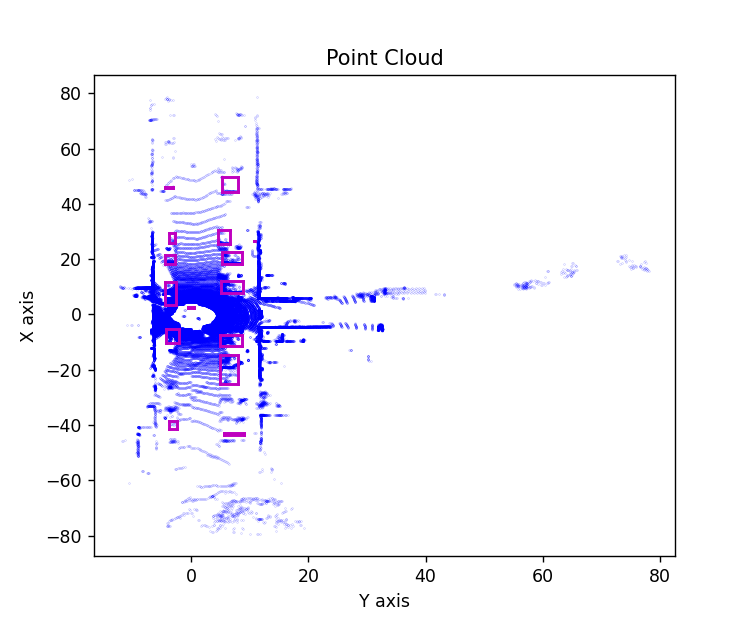

In [578]:
f = plt.figure(figsize=(6, 5))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw_point_cloud(scan, ax, 'Point Cloud',axes=axes)
for box in box_coord_list:
     draw_box(ax, box, axes=axes, color='m')

## Getting bounding boxes for sequence 00

In [670]:
import glob
scan_lst = glob.glob("dataset/sequences/00/velodyne/*.bin")
labels_lst = glob.glob("dataset/sequences/00/labels/*.label")
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [674]:
# getting num of scan
import re
def get_scan_id(scan):
    return re.findall(r'\d\d\d\d\d.', scan)[0]

print(scan_lst[0])
print(get_scan_id(scan_lst[0]))

dataset/sequences/00/velodyne/000355.bin
000355


In [672]:
%%time
# get bboxes
for scan, label in zip(sorted(scan_lst), sorted(labels_lst)):
    
    # sanity check
    scan_id = get_scan_id(scan)
    assert scan_id == get_scan_id(label)
    
    # read scan
    scan = np.fromfile(scan, dtype=np.float32)
    scan = scan.reshape((-1, 4))[:, :3]

    # read label
    label = np.fromfile(label, dtype=np.uint32)
    label = label.reshape((-1))
    
    # start pipeline 
    clusters = pipeline(scan, label, obstacle_lst)
    
    # write cluster in format x_min, x_max, y_min, y_max, z_min, z_max
    np.savetxt('dataset/sequences/00/clusters/' + str(scan_id) + '.bbox', clusters)

get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding

get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes


In [86]:
# def clustering(cloud, tol, min_size, max_size):
#     """
#     Input parameters:
#         cloud: Input cloud
#         tol: tolerance
#         min_size: minimal number of points to form a cluster
#         max_size: maximal number of points that a cluster allows 
#     Output:
#         cluster_indices: a list of list. Each element list contains the indices of the points that belongs to
#                          the same cluster
#     """
#     tree = cloud.make_kdtree()
#     ec = cloud.make_EuclideanClusterExtraction()
#     ec.set_ClusterTolerance(tol)
#     ec.set_MinClusterSize(min_size)
#     ec.set_MaxClusterSize(max_size)
#     ec.set_SearchMethod(tree)
#     cluster_indices = ec.Extract()
#     return cluster_indices